In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import gc
import torch.utils.data as Data
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import Adam



class MLP(nn.Module):   #set model
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(3,32)
        self.hidden2 = nn.Linear(32,32)
        self.hidden3 = nn.Linear(32,32)
        self.hidden4 = nn.Linear(32,32)
        self.hidden5 = nn.Linear(32,32)
        self.hidden6 = nn.Linear(32,32)
        self.hidden7 = nn.Linear(32,4)
    def forward(self,input): 
        out = self.hidden1(input)
        out = F.relu(out)
        out = self.hidden2(out)
        out = F.relu(out)
        out = self.hidden3(out)
        out = F.relu(out)
        out = self.hidden4(out)
        out = F.relu(out)
        out = self.hidden5(out)
        out = F.relu(out)
        out = self.hidden6(out)
        out = F.relu(out)
        out = self.hidden7(out)
        return out

net = MLP().double()

In [2]:
def cal_energy(velocity, m=1):  #kinetic energy equation
    return 0.5*m*(float(velocity[0]**2)+float(velocity[1]**2))
def evaluation(model, batchh, ifpred=True, mass=1): #get pred/true crd&velocity&Ek&t data
    crd, vel, energy, t = [], [], [], []
    for i in range(9,399): #get the data at t10~t399(total traj starts at t0 and ends at t400)
        if ifpred:  #get predicted data
            x11, x12, t1 = model(batchh[0][i])[:2], model(batchh[0][i])[2:4], float(batchh[0][i][0]) #ti时刻的坐标
            xn1, xn2 = model(batchh[0][i+1])[:2], model(batchh[0][i+1])[2:4]#x(i+1)
            x21, x22, t2 = model(batchh[0][i+2])[:2], model(batchh[0][i+2])[2:4], float(batchh[0][i+2][0])
            x13 = -x11-x12  #format: 2D tensor
            x23 = -x21-x22
            crd.append((xn1, xn2, -xn1-xn2)) #get coordinate data
            v1, v2, v3 = (x21-x11)/(t2-t1), (x22-x12)/(t2-t1), (x23-x13)/(t2-t1) #format: 2D tensor
            vel.append((v1, v2, v3))  #get velocity(v(i+1) is mean velocity during ti~t(i+2))
            energy.append((cal_energy(v1),cal_energy(v2),cal_energy(v3))) #get Ek(i+1)
        else:  #load the true data from the traj file
            t1 = float(batchh[0][i][0])
            xn1, xn2 = batchh[1][i+1][:2], batchh[1][i+1][2:4]
            v1, v2, v3 = batchh[2][i+1][:2], batchh[2][i+1][2:4], batchh[2][i+1][4:6]
            crd.append((xn1, xn2, -xn1-xn2))
            vel.append((v1, v2, v3))
            energy.append((cal_energy(v1),cal_energy(v2),cal_energy(v3))) 
        t.append(t1)
    return crd, vel, energy, t
# a batch is a dataloader, which contains three parts: 
# batch[0] is the input data, which contains t and x2(initial)
# batch[1] is the true data of x1(t), x2(t)
# batch[2] is the true data of v1(t), v2(t), v3(t)
# you can also see these below

In [3]:
def get_dataset(filepath, n_traj):  #transform the traj to Dataset
    _f = open(filepath, 'r')
    _X = np.zeros((n_traj*401,3)) # the input data, which contains t and x2(initial)
    _Y = np.zeros((n_traj*401,4)) # the true data of x1(t), x2(t)
    _Z = np.zeros((n_traj*401,6)) # the true data of v1(t), v2(t), v3(t)
    _x2_init = np.zeros((2))
    for i in range(401*n_traj):
        _line1 = [float(i) for i in _f.readline().split()]
        _line2 = [float(i) for i in _f.readline().split()]
        _line3 = [float(i) for i in _f.readline().split()]
        _f.readline()
        if (i%401 ==0):
            _x2_init = _line2[4:6]
        _X[i] = _line1[2:3] + _x2_init
        _Y[i] = _line1[4:6] + _line2[4:6]
        _Z[i] = _line1[7:9] + _line2[7:9] + _line2[7:9]
    return Data.TensorDataset(torch.from_numpy(_X),torch.from_numpy(_Y), torch.from_numpy(_Z))

testset = get_dataset(r'D:\working\working\ML\NVM-master\traj\dNB.50.traj', 50) 
#read 50 trajs of the file
testloader = Data.DataLoader(testset, 401, shuffle = False, drop_last = False)  
#divide the data into 50 batches(each contains 401 frames)

net.load_state_dict(torch.load("./checkpoints/model_ann20+.pt"))
crd, vel, energy, t = [],[],[],[] # predicted data
crd_true, vel_true, energy_true, t = [],[],[],[] # true data
for x,batch in enumerate(testloader):  
    crd_x, vel_x, energy_x, t_x = evaluation(net, batch)  # predicted data of each batch
    crd_true_x, vel_true_x, energy_true_x, t_x = evaluation(net, batch, False)
    crd += crd_x
    vel += vel_x
    energy += energy_x
    t += t_x
    crd_true += crd_true_x
    vel_true += vel_true_x
    energy_true += energy_true_x

In [4]:
with open(r'D:\working\working\ML\NVM-master\crd_pred.txt',mode='w') as f1\
,open(r'D:\working\working\ML\NVM-master\vel_pred.txt',mode='w') as f2\
,open(r'D:\working\working\ML\NVM-master\energy_pred.txt',mode='w') as f3:
    for i in crd:
        f1.write(f'{i[0][0]:<12.8f}{i[0][1]:<12.8f}{i[1][0]:<12.8f}{i[1][1]:<12.8f}{i[2][0]:<12.8f}{i[2][1]:<12.8f}\n')
    for i in vel:
        f2.write(f'{i[0][0]:<12.8f}{i[0][1]:<12.8f}{i[1][0]:<12.8f}{i[1][1]:<12.8f}{i[2][0]:<12.8f}{i[2][1]:<12.8f}\n')
    for i in energy:
        f3.write(f'{i[0]:<12.8f}{i[1]:<12.8f}{i[2]:<12.6f}\n')
with open(r'D:\working\working\ML\NVM-master\crd_true.txt',mode='w') as f4\
,open(r'D:\working\working\ML\NVM-master\vel_true.txt',mode='w') as f5\
,open(r'D:\working\working\ML\NVM-master\energy_true.txt',mode='w') as f6:
    for i in crd_true:
        f4.write(f'{i[0][0]:<12.8f}{i[0][1]:<12.8f}{i[1][0]:<12.8f}{i[1][1]:<12.8f}{i[2][0]:<12.8f}{i[2][1]:<12.8f}\n')
    for i in vel_true:
        f5.write(f'{i[0][0]:<12.8f}{i[0][1]:<12.8f}{i[1][0]:<12.8f}{i[1][1]:<12.8f}{i[2][0]:<12.8f}{i[2][1]:<12.8f}\n')
    for i in energy_true:
        f6.write(f'{i[0]:<12.8f}{i[1]:<12.8f}{i[2]:<12.6f}\n')

In [5]:
def cal_MAE(crd_of_pred, crd_of_true): # calculate MAE(Mean absolute error of coordinate)
    _MAE = 0
    _length = len(crd_of_pred)
    for i in range(_length):
        for j in range(3):
            _MAE += torch.pairwise_distance(crd_of_pred[i][j], crd_of_true[i][j])
    return _MAE/(3*_length)
def cal_REE(energy_of_pred, energy_of_true): # calculate REE(relative energy error)
    _REE = 0
    _length = len(energy_of_pred)
    for i in range(_length):
        _REE += abs(sum(energy_of_pred[i])-sum(energy_of_true[i]))/sum(energy_of_true[i])
    return _REE/(_length)
mae = cal_MAE(crd, crd_true)
ree = cal_REE(energy, energy_true)
print(f'MAE is {mae}')
print(f'REE is {ree}')


MAE is 0.05852424899845553
REE is 0.5567749294872907


390


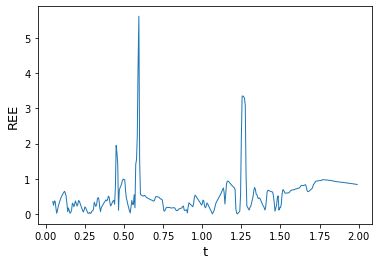

In [21]:
import os
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
def cal_REE_2(energy_of_pred, energy_of_true): # calculate REE(relative energy error) at each time
    _REE = []
    _length = len(energy_of_pred)
    for i in range(_length):
        _REE.append(abs(sum(energy_of_pred[i])-sum(energy_of_true[i]))/sum(energy_of_true[i]))
    return _REE
print(len(t))
REE = cal_REE_2(energy[:390], energy_true[:390])
plt.plot(t, REE, linewidth=1.0)
plt.xlabel("t",fontsize=13)
plt.ylabel("REE",fontsize=13)
plt.savefig('REE-t.png')